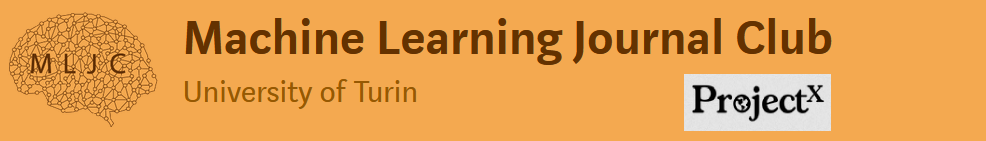

### Fireline Comparison One Fire 

In [3]:
#!pip3 install opencv-python

In [53]:
import numpy as np 
import cv2 as cv
from scipy.spatial.distance import directed_hausdorff
from matplotlib import pyplot as plt 
import glob 
import seaborn as sns

In [38]:
level_set_names  = glob.glob("./level_set_final/one_fire/*.png")
wrf_tensor_names = glob.glob("./WRF_tensor/one_fire/*.png")

In [39]:
level_set_images = []
wrf_tensor_images = []

for i in range(0,len(level_set_names)):
    level_set_images.append(cv.imread(level_set_names[i]))
    wrf_tensor_images.append(cv.imread(wrf_tensor_names[i]))

In [40]:
def fln_distance_closed(img_pinn,img_wrf, symmetric_hausdorff = False):
    
    """
    Comparing firelines with Hausdorff distance
      * About hausdorff distance:
        https://arxiv.org/abs/0909.4642#:~:text=The%20actual%20position%20of%20an,are%20several%20cases%20to%20consider
  
    
    img_pinn: fireline image extracted from Julia's file
    img_wrf: fireline image extracted from WRF tensor's time slice
    symmetric_hausdorff = False, because we use the hausdorff distance 
        between two matrices, which is non-symmetric by default
        see implementation details on scipy's docs
        
        
    return: Hausdorff distance between the two contours
    
     """
        
    # Image 1 - PINN
    img_pinn = cv.cvtColor(img_pinn, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_pinn = img_pinn[:550,50:550] 
        
    # Image 2 - WRF out 
    img_wrf = cv.cvtColor(img_wrf, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_wrf = img_wrf[:550,50:550]
    
    
    if symmetric_hausdorff is False:     
        dist = directed_hausdorff(img_pinn ,img_wrf)[0]
    else: 
        dist = max(directed_hausdorff(img_pinn, img_wrf)[0], directed_hausdorff(img_pinn, img_wrf)[0])  
    
    return dist
    

In [41]:
distances = []

for i in range(0,len(level_set_images)):
    distances.append(fln_distance_closed(level_set_images[i],wrf_tensor_images[i]))

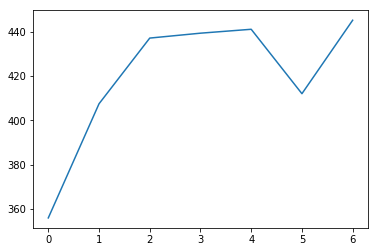

In [69]:
plt.plot(distances)

In [43]:
# To extract area

def get_contour_area(img_pinn, img_wrf):
         
    # Image 1 - PINN - Area Preprocessing 
    img_pinn = cv.cvtColor(img_pinn, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_pinn = img_pinn[:550,50:550] 
    # Applying erosion for computational stability
    kernel = np.ones((5,5),np.uint8)
    img_pinn = cv.erode(img_pinn, kernel, iterations = 1)
    
    # Image 2 - WRF out - Area Preprocessing
    img_wrf = cv.cvtColor(img_wrf, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_wrf = img_wrf[:550,50:550]
    kernel = np.ones((5,5),np.uint8)
    img_wrf = cv.erode(img_wrf, kernel, iterations = 1)

    # Image 1 - PINN - Area extraction
    ret1, thresh1 = cv.threshold(img_pinn, 200, 255, 0)
    contours1, hierarchy1 = cv.findContours(thresh1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt1 = max(contours1, key=lambda coll: len(coll))
    area_pinn = cv.contourArea(cnt1)
    

    # Image 2 - WRF out - Area Extraction
    ret2, thresh2 = cv.threshold(img_wrf, 200, 255, 0)
    contours2, hierarchy2 = cv.findContours(thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt2 = max(contours2, key=lambda coll: len(coll))
    area_wrf = cv.contourArea(cnt2)
         
    return area_pinn, area_wrf

# To extract perimeter 
def get_contour_perimeter(img_pinn, img_wrf):
    
    # Image 1 - PINN - Area Preprocessing 
    img_pinn = cv.cvtColor(img_pinn, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_pinn = img_pinn[:550,50:550] 
    # Applying erosion for computational stability
    kernel = np.ones((8,8),np.uint8)
    img_pinn = cv.erode(img_pinn, kernel, iterations = 1)
    
    # Image 2 - WRF out - Area Preprocessing
    img_wrf = cv.cvtColor(img_wrf, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_wrf = img_wrf[:550,50:550]
    kernel = np.ones((8,8),np.uint8)
    img_wrf = cv.erode(img_wrf, kernel, iterations = 1)

    # Image 1 - PINN - Area extraction
    ret1, thresh1 = cv.threshold(img_pinn, 200, 255, 0)
    contours1, hierarchy1 = cv.findContours(thresh1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt1 = max(contours1, key=lambda coll: len(coll))
    perimeter_pinn = cv.arcLength(cnt1,True)

    # Image 2 - WRF out - Area Extraction
    ret2, thresh2 = cv.threshold(img_wrf, 200, 255, 0)
    contours2, hierarchy2 = cv.findContours(thresh2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt2 = max(contours2, key=lambda coll: len(coll))
    perimeter_wrf = cv.arcLength(cnt2,True) 

    return perimeter_pinn, perimeter_wrf

In [44]:
areas_pinn = []
areas_wrf = []

for i in range(0,len(level_set_images)):
    a_pinn, a_wrf = get_contour_area(level_set_images[i], wrf_tensor_images[i])
    
    areas_pinn.append(a_pinn)
    areas_wrf.append(a_wrf)

In [45]:
perimeters_pinn = []
perimeters_wrf = []

for i in range(0,len(level_set_images)):
    p_pinn, p_wrf = get_contour_perimeter(level_set_images[i], wrf_tensor_images[i])
    
    perimeters_pinn.append(p_pinn)
    perimeters_wrf.append(p_wrf)

In [72]:
import mpltex

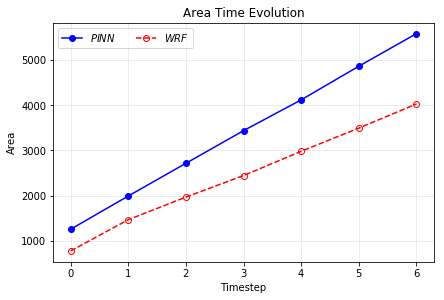

In [118]:
fig, ax = plt.subplots(1)

linestyles = mpltex.linestyle_generator(colors = ["blue","red"])
ax.plot(np.asarray(areas_pinn),label='$PINN$', **next(linestyles))
ax.plot(np.asarray(areas_wrf), label='$WRF$', **next(linestyles))

ax.set_title("Area Time Evolution")
ax.set_xlabel('Timestep')
ax.set_ylabel('Area')
ax.legend(loc='best', ncol=2)
ax.grid(alpha = 0.3)
fig.tight_layout(pad=0.1)
fig.savefig("areas_one_fire.pdf")

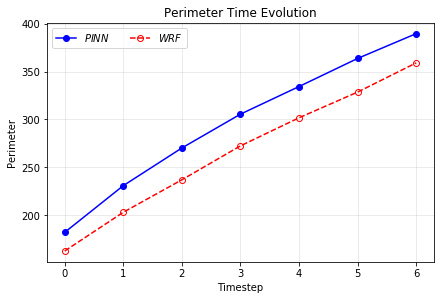

In [117]:
fig, ax = plt.subplots(1)

linestyles = mpltex.linestyle_generator(colors = ["blue","red"])
ax.plot(np.asarray(perimeters_pinn),label='$PINN$', **next(linestyles))
ax.plot(np.asarray(perimeters_wrf), label='$WRF$', **next(linestyles))

ax.set_title("Perimeter Time Evolution")
ax.set_xlabel('Timestep')
ax.set_ylabel('Perimeter')
ax.legend(loc='best', ncol=2)
ax.grid(alpha = 0.3)
fig.tight_layout(pad=0.1)
fig.savefig("perimeters_one_fire.pdf")

In [47]:
norm_area_distance = []
for i in range(0,len(level_set_images)):
    area = max(areas_pinn[i], areas_wrf[i])
    norm_area_distance.append(distances[i]/area)
    
norm_perim_distance = []
for i in range(0,len(level_set_images)):
    perim = max(perimeters_pinn[i], perimeters_wrf[i])
    norm_perim_distance.append(distances[i]/perim)
    
norm_area_distance = np.asarray(norm_area_distance)
norm_perim_distance = np.asarray(norm_perim_distance)

In [57]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

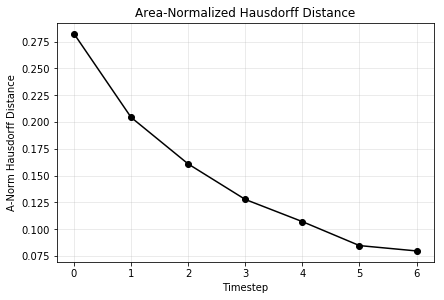

In [121]:
fig, ax = plt.subplots(1)

linestyles = mpltex.linestyle_generator(colors = ["black"])
ax.plot(np.asarray(norm_area_distance), **next(linestyles))

ax.set_title("Area-Normalized Hausdorff Distance")
ax.set_ylabel('A-Norm Hausdorff Distance')
ax.set_xlabel('Timestep')
ax.grid(alpha = 0.3)
fig.tight_layout(pad=0.1)
fig.savefig("norm_area_haudorff_one_fire.pdf")

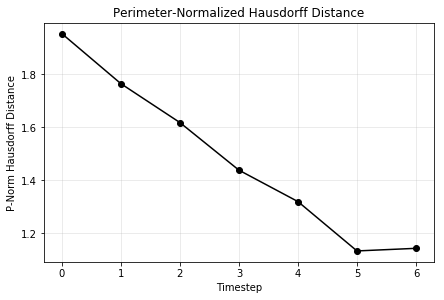

In [120]:
fig, ax = plt.subplots(1)

linestyles = mpltex.linestyle_generator(colors = ["black"])
ax.plot(np.asarray(norm_perim_distance), **next(linestyles))

ax.set_title("Perimeter-Normalized Hausdorff Distance")
ax.set_ylabel('P-Norm Hausdorff Distance')
ax.set_xlabel('Timestep')
ax.grid(alpha = 0.3)
fig.tight_layout(pad=0.1)
fig.savefig("norm_perim_haudorff_one_fire.pdf")

In [15]:
def fln_distance(img_pinn,img_wrf, symmetric_hausdorff = False):
    
    """
    Image Preprocessing for extrapolating contours
    
    img_pinn: fireline image extracted from Julia's file
    img_wrf: fireline image extracted from WRF tensor's time slice
    symmetric_hausdorff = False, because we use the hausdorff distance 
        between two matrices, which is non-symmetric by default
        see implementation details on scipy's docs
        
        
    return: Hausdorff distance between the two contours
    
    About hausdorff distance:
    https://arxiv.org/abs/0909.4642#:~:text=The%20actual%20position%20of%20an,are%20several%20cases%20to%20consider
    """
        
    # Image 1 - PINN
    img_pinn = cv.cvtColor(img_pinn, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_pinn = img_pinn[:550,50:550] 
    kernel = np.ones((10,10),np.uint8)
    img_pinn = cv.erode(img_pinn, kernel, iterations = 1)
        
    # Image 2 - WRF out 
    img_wrf = cv.cvtColor(img_wrf, cv.COLOR_BGR2GRAY)
    # reshape in order to exclude axis, images are (600x600) 
    img_wrf = img_wrf[:550,50:550]
    img_wrf = cv.erode(img_wrf, kernel, iterations = 1)
    
    ### Extracting fireline area as a mask ###
    
    # Image 1, thresholds have been fine-tuned 
    ret1,thresh1 = cv.threshold(img_pinn, 100 ,255, cv.THRESH_BINARY )
    kernel1 = cv.getStructuringElement(cv.MORPH_RECT, (1,1))
    close1 = cv.morphologyEx(thresh1, cv.MORPH_CLOSE, kernel1, iterations=1)
    cnts1 = cv.findContours(close1,2, 1)
    cnts1 = cnts1[0] if len(cnts1) == 2 else cnts1[1]
    mask1 = cv.fillPoly(close1, cnts1, [200,200,200])
    
    
    # Image 2, thresholds have been fine-tuned 
    ret2,thresh2 = cv.threshold(img_wrf, 0 ,255, cv.THRESH_BINARY )
    kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1,1))
    close2 = cv.morphologyEx(thresh2, cv.MORPH_CLOSE, kernel2, iterations=1)
    cnts2 = cv.findContours(close2,2, 1)
    cnts2 = cnts2[0] if len(cnts2) == 2 else cnts2[1]
    mask2 = cv.fillPoly(close2, cnts2, [200,200,200])
    
    if symmetric_hausdorff is False:     
        dist = directed_hausdorff(mask1 ,mask2)[0]
    else: 
        dist = max(directed_hausdorff(mask1, mask2)[0], directed_hausdorff(mask1, mask2)[0])
    
    return dist